# In-Class Quiz Nº 4

<hr style="border:1px  solid black"> </hr>

### (Fill in)
## Name: ruben santos
## Number: A49063

<hr style="border:1px  solid black"> </hr>

## Develop and run the requested code in the cells immediately below the questions.

# IMPORTANTE:
## Once completed, save this Jupyter notebook with the following name:
## Axxxxx-Q4.ipynb (Axxxxx: student number)
##  and then upload the file to the Moodle link provided for that purpose.

<hr style="border:2px solid black"> </hr>

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix, roc_curve
from time import time

<hr style="border:2px solid black"> </hr>

# Data: Cats and Dogs dataset (small version) - zip file $\texttt{CatsDogsSmall.zip}$
## This file is divided into two directories (train and test)
## Each one has two sub-directories (dogs and cats)
## The training data consists of a 1000 images of cats and 1000 images of dogs
## The test data consists of 500 images of cats and 500 images of dogs
## The images have various sizes

# Questions:
##### Consider that  we want to use transfer learning to build a CNN to perform a binary classification of the images (either a cat or a dog). Additionally with want to use data augmentation during the training process. 
##### Note that you should be aware of the computational capacity of your system.  Choose the pre-trained network and parameter values such as the input image size or batch training size accordingly.
##### 1.  Pick a pre-trained network of your choice and incorporate it in a CNN to tackle this problem. Build and compile the CNN. 
##### 2.  Using the {ImageDataGenerator}$ from Keras, build two generators (one for training and the other for testing). Note that the training generator has to include data augmentation. Pick one image of a dog and one image of a cat. Show these two original images and five versions of each image with data augmentation.
##### 3.  Train the network for at least 10 epochs and show the results. Also include the test data as the validation set during training. Make sure to set the {steps_per_epoch}$ and the ${validation_steps}$ so that each training epoch runs through the all the training and test images. Show the evolution of the accuracies and the losses during training and print the number of errors and the confusion matrix for the test data.
##### 4. Find the operational point of the classifier in Question 3. Calibrate the classifier in order to have approximately the same number of false positives an false negatives. Plot the ROC curve of this classifier with the test data. Include in this plot the operational points of the classifier before and after calibration

## 1.

In [45]:
# Consider that  we want to use transfer learning to build a CNN to 
# perform a binary classification of the images (either a cat or a dog). 
# Additionally with want to use data augmentation during the training process. 
# Note that you should be aware of the computational capacity of your system.  
# Choose the pre-trained network and parameter values such as the input image 
# size or batch training size accordingly.
## 1.  Pick a pre-trained network of your choice and incorporate it in a 
# CNN to tackle this problem. Build and compile the CNN. 

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input


input_shape = (128, 128, 3)

cnn_base = MobileNetV2(weights='imagenet', include_top=False, 
                       input_shape=input_shape)

cnn_base.trainable = False

cnn_cats_dogs = keras.models.Sequential()
cnn_cats_dogs.add(cnn_base)
cnn_cats_dogs.add(keras.layers.Flatten())
cnn_cats_dogs.add(keras.layers.Dense(2, activation='softmax'))

cnn_cats_dogs.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_cats_dogs.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 40962     
                                                                 
Total params: 2,298,946
Trainable params: 40,962
Non-trainable params: 2,257,984
_________________________________________________________________


## 2.

In [46]:
# 2.  Using the {ImageDataGenerator}$ from Keras, 
# build two generators (one for training and the other for testing). 
# Note that the training generator has to include data augmentation. 

from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator


db_dir = './CatsDogsSmall'
batch_size = 100

input_shape = (128, 128, 3)
image_size = input_shape[:2]

data_gen_augm = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = data_gen_augm.flow_from_directory(
    db_dir + '/train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = data_gen.flow_from_directory(
    db_dir + '/test',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [2]:
# Pick one image of a dog and one image of a cat. Show these two 
# original images and five versions of each image with data 
# augmentation.

from matplotlib.image import imread

# cat

cat = imread(db_dir + '/train/cats/cat0024.jpg')
print(cat.shape)
cat_gen = data_gen_augm.flow(np.array([cat]), batch_size=1)

plt.figure(figsize=(10,5))
plt.subplot2grid((2,5), (0,0))
plt.imshow(cat)

for i in range(5):
    plt.subplot2grid((2,5), (1,i))
    plt.imshow(cat_gen.next().squeeze()[:, :, ::-1])
plt.show()

# dog

dog = imread(db_dir + '/train/dogs/dog0023.jpg')
dog_gen = data_gen_augm.flow(np.array([dog]), batch_size=1)

plt.figure(figsize=(10,5))
plt.subplot2grid((2,5), (0,0))
plt.imshow(dog)
for i in range(5):
    plt.subplot2grid((2,5), (1,i))
    plt.imshow(dog_gen.next().squeeze())
plt.show()

NameError: name 'db_dir' is not defined

## 3.

In [48]:
# 3. Train the network for at least 10 epochs and show the results. 
# Also include the test data as the validation set during training. 
# Make sure to set the {steps_per_epoch}$ and the ${validation_steps
#  so that each training epoch runs through the all the training and 
# test images. 

epochs = 10
steps_per_epoch = train_gen.n // batch_size
validation_steps = test_gen.n // batch_size

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           restore_best_weights=True)
best_model = keras.callbacks.ModelCheckpoint('best_model_cats_dogs.h5', 
                                             monitor='val_loss', 
                                             save_best_only=True)

cnn_cats_dogs_train = cnn_cats_dogs.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_gen,
    validation_steps=validation_steps,
    callbacks=[early_stop, best_model]
)

# Show the results

Epoch 1/10
20/20 [==============================] - 45s 2s/step - loss: 0.4691 - accuracy: 0.8825 - val_loss: 0.1291 - val_accuracy: 0.9680
Epoch 2/10
20/20 [==============================] - 42s 2s/step - loss: 0.1710 - accuracy: 0.9475 - val_loss: 0.1358 - val_accuracy: 0.9680
Epoch 3/10
20/20 [==============================] - 50s 3s/step - loss: 0.1263 - accuracy: 0.9655 - val_loss: 0.1209 - val_accuracy: 0.9700
Epoch 4/10
20/20 [==============================] - 55s 3s/step - loss: 0.1254 - accuracy: 0.9625 - val_loss: 0.1237 - val_accuracy: 0.9720
Epoch 5/10
20/20 [==============================] - 45s 2s/step - loss: 0.1072 - accuracy: 0.9620 - val_loss: 0.1217 - val_accuracy: 0.9670
Epoch 6/10
20/20 [==============================] - 45s 2s/step - loss: 0.0889 - accuracy: 0.9695 - val_loss: 0.1504 - val_accuracy: 0.9650
Epoch 7/10
20/20 [==============================] - 44s 2s/step - loss: 0.1098 - accuracy: 0.9675 - val_loss: 0.1919 - val_accuracy: 0.9650
Epoch 8/10
20/20 [==

In [1]:
I = imread(db_dir + '/train/dogs/dog0023.jpg')
I = preprocess_input(I.reshape(1, *image_size))
p = cnn_cats_dogs.predict(I)
print(p)


NameError: name 'imread' is not defined

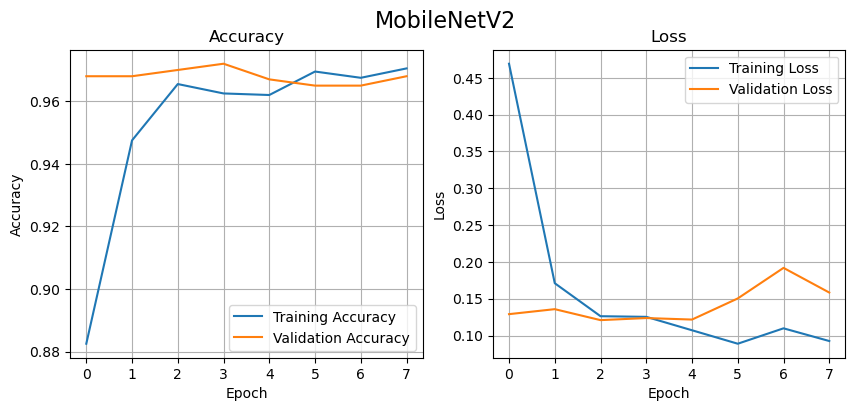

In [49]:
# Show the evolution of the accuracies and the losses during training and 

h=cnn_cats_dogs_train.history
fig, (acc, loss) = plt.subplots(1, 2, figsize=(10, 4))

loss.plot(h['loss'], label='Training Loss')
loss.plot(h['val_loss'], label='Validation Loss')
loss.set_title('Loss')
loss.set_xlabel('Epoch')
loss.set_ylabel('Loss')
loss.legend()
loss.grid(True)
# loss.set_xlim([0,epochs])
# loss.axis([0,epochs])

acc.plot(h['accuracy'], label='Training Accuracy')
acc.plot(h['val_accuracy'], label='Validation Accuracy')
acc.set_title('Accuracy')
acc.set_xlabel('Epoch')
acc.set_ylabel('Accuracy')
acc.legend()
acc.grid(True)

# acc.set_xlim([0,epochs])

# acc.axis([0,epochs,0,1])

fig.suptitle('MobileNetV2', fontsize=16)
plt.show()

In [50]:
# print the number of errors and the confusion matrix for the test data.

test_gen.reset()
cnn_cats_dogs_y_true = test_gen.classes
cnn_cats_dogs_y_pred = cnn_cats_dogs.predict(test_gen, 
                                             steps=test_gen.n / batch_size)
cnn_cats_dogs_y_pred = np.argmax(cnn_cats_dogs_y_pred, 
                                 axis=1)

print('Confusion matrix:')
cm1 = confusion_matrix(cnn_cats_dogs_y_true, cnn_cats_dogs_y_pred)
print(cm1)
print('Number of errors: {}'
      .format(np.sum(cnn_cats_dogs_y_pred != cnn_cats_dogs_y_true)))
print('Accuracy: {}'.format(np.sum(cnn_cats_dogs_y_pred == cnn_cats_dogs_y_true) 
                            / len(cnn_cats_dogs_y_true)))

10/10 [==============================] - 14s 1s/step
Confusion matrix:
[[480  20]
 [ 10 490]]
Number of errors: 30
Accuracy: 0.97


## 4.

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

10/10 [==============================] - 15s 1s/step
[[487  13]
 [ 16 484]]
Point with the same number of false positives an false negatives 0.7778187


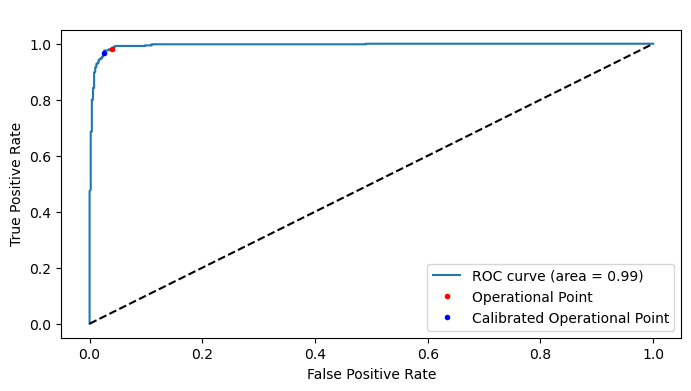

In [53]:
# 4. Find the operational point of the classifier in Question 3. 
# Calibrate the classifier in order to have approximately the same number of false 
# positives an false negatives. Plot the ROC curve of this classifier with the 
# test data. Include in this plot the operational points of the classifier 
# before and after calibration


y_pred_prob = cnn_cats_dogs.predict(test_gen)
y_true = test_gen.classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
auc = roc_auc_score(y_true, y_pred_prob[:, 1])


threshold = 0.860
y2_pred2 = (y_pred_prob > threshold).astype(int)
cm2 = confusion_matrix(y_true, y2_pred2[:, 1])
print(cm2)
# calculate false positive rate and true positive rate of cm2 and cm1
fpP1 = cm1[0,1]/(cm1[0,1]+cm1[0,0])
tpP1 = cm1[1,1]/(cm1[1,1]+cm1[1,0])

fpP2 = cm2[0,1]/(cm2[0,1]+cm2[0,0])
tpP2 = cm2[1,1]/(cm2[1,1]+cm2[1,0])

# melhor ponto - approximately the same number of false positives an false negatives
print("Point with the same number of false positives an false negatives", thresholds[np.argmax(tpr - fpr)]) 

plt.figure(figsize=(8, 4))
plt.title('ROC curve for Cats and Dogs')
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpP1, tpP1, 'r.', label='Operational Point')
plt.plot(fpP2, tpP2, 'b.', label='Calibrated Operational Point')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ')
plt.legend()
plt.show()
